### Loading Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve, precision_score, recall_score, precision_recall_curve
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
df = pd.read_csv("./churn_prediction.csv")
df.shape

(28382, 21)

In [3]:
df.head()

,customer_id,vintage,age,gender,dependents,occupation,city,customer_nw_category,branch_code,days_since_last_transaction,...,previous_month_end_balance,average_monthly_balance_prevQ,average_monthly_balance_prevQ2,current_month_credit,previous_month_credit,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance,churn
0,1,3135,66,Male,0.0,self_employed,187.0,2,755,224.0,...,1458.71,1458.71,1449.07,0.20,0.20,0.20,0.20,1458.71,1458.71,0
1,2,310,35,Male,0.0,self_employed,NaN,2,3214,60.0,...,8704.66,7799.26,12419.41,0.56,0.56,5486.27,100.56,6496.78,8787.61,0
2,4,2356,31,Male,0.0,salaried,146.0,2,41,NaN,...,5815.29,4910.17,2815.94,0.61,0.61,6046.73,259.23,5006.28,5070.14,0
3,5,478,90,NaN,NaN,self_employed,1020.0,2,582,147.0,...,2291.91,2084.54,1006.54,0.47,0.47,0.47,2143.33,2291.91,1669.79,1
4,6,2531,42,Male,2.0,self_employed,1494.0,3,388,58.0,...,1401.72,1643.31,1871.12,0.33,714.61,588.62,1538.06,1157.15,1677.16,1


### Checking for Missing Values

In [4]:
pd.isnull(df).sum()

customer_id                          0
vintage                              0
age                                  0
gender                             525
dependents                        2463
occupation                          80
city                               803
customer_nw_category                 0
branch_code                          0
days_since_last_transaction       3223
current_balance                      0
previous_month_end_balance           0
average_monthly_balance_prevQ        0
average_monthly_balance_prevQ2       0
current_month_credit                 0
previous_month_credit                0
current_month_debit                  0
previous_month_debit                 0
current_month_balance                0
previous_month_balance               0
churn                                0
dtype: int64

In [5]:
df.gender.value_counts()

Male      16548
Female    11309
Name: gender, dtype: int64

In [6]:
# Since the difference in frequency between male and female is not significant, we create a third column to fill those missing values with -1
#Encoding Male with 1, Female with 0 and NAN with -1

dictGender = {"Male" : 1, "Female" : 0}
df.replace({"gender" : dictGender}, inplace = True)
df.gender = df.gender.fillna(-1);
df.gender.head(10)

0    1.0
1    1.0
2    1.0
3   -1.0
4    1.0
5    0.0
6    1.0
7    1.0
8    1.0
9    1.0
Name: gender, dtype: float64

In [7]:
df.dependents.value_counts()

0.0     21435
2.0      2150
1.0      1395
3.0       701
4.0       179
5.0        41
6.0         8
7.0         3
36.0        1
52.0        1
25.0        1
9.0         1
50.0        1
32.0        1
8.0         1
Name: dependents, dtype: int64

In [8]:
# Since for dependents : 0.0 ; has a larger majority, we fill missing values with 0.0
df.dependents = df.dependents.fillna(0)
df.dependents.head(10)

0    0.0
1    0.0
2    0.0
3    0.0
4    2.0
5    0.0
6    0.0
7    0.0
8    0.0
9    3.0
Name: dependents, dtype: float64

In [9]:
# Similarly for occupation
df.occupation.value_counts()

self_employed    17476
salaried          6704
student           2058
retired           2024
company             40
Name: occupation, dtype: int64

In [10]:
df.occupation = df.occupation.fillna("self_employed")
df.occupation.head(10)

0    self_employed
1    self_employed
2         salaried
3    self_employed
4    self_employed
5    self_employed
6          retired
7    self_employed
8         salaried
9    self_employed
Name: occupation, dtype: object

In [11]:
df.city.value_counts()

1020.0    3479
1096.0    2016
409.0     1334
146.0     1291
834.0     1138
          ... 
629.0        1
527.0        1
1212.0       1
530.0        1
70.0         1
Name: city, Length: 1604, dtype: int64

In [12]:
# Similarly for city
df.city = df.city.fillna(1020)
df.city.head(10)

0     187.0
1    1020.0
2     146.0
3    1020.0
4    1494.0
5    1096.0
6    1020.0
7     623.0
8    1096.0
9    1020.0
Name: city, dtype: float64

In [13]:
# For customer with days_since_last_transaction > 365 ; we replace missing values with a value far greater than 365
df["days_since_last_transaction"] = df["days_since_last_transaction"].fillna(999)
df["days_since_last_transaction"].head(10)

0    224.0
1     60.0
2    999.0
3    147.0
4     58.0
5     60.0
6     98.0
7    172.0
8     19.0
9      0.0
Name: days_since_last_transaction, dtype: float64

### Preprocessing Data

In [14]:
# Dummy values with multiple categories
df = pd.concat([df, pd.get_dummies(df.occupation, prefix = str("occupation"), prefix_sep='_')], axis = 1)
df.head()

,customer_id,vintage,age,gender,dependents,occupation,city,customer_nw_category,branch_code,days_since_last_transaction,...,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance,churn,occupation_company,occupation_retired,occupation_salaried,occupation_self_employed,occupation_student
0,1,3135,66,1.0,0.0,self_employed,187.0,2,755,224.0,...,0.20,0.20,1458.71,1458.71,0,0,0,0,1,0
1,2,310,35,1.0,0.0,self_employed,1020.0,2,3214,60.0,...,5486.27,100.56,6496.78,8787.61,0,0,0,0,1,0
2,4,2356,31,1.0,0.0,salaried,146.0,2,41,999.0,...,6046.73,259.23,5006.28,5070.14,0,0,0,1,0,0
3,5,478,90,-1.0,0.0,self_employed,1020.0,2,582,147.0,...,0.47,2143.33,2291.91,1669.79,1,0,0,0,1,0
4,6,2531,42,1.0,2.0,self_employed,1494.0,3,388,58.0,...,588.62,1538.06,1157.15,1677.16,1,0,0,0,1,0


In [15]:
# Scaling Data for Linear Calculation
num_cols = ['customer_nw_category', 'current_balance',
            'previous_month_end_balance', 'average_monthly_balance_prevQ2', 'average_monthly_balance_prevQ',
            'current_month_credit', 'previous_month_credit', 'current_month_debit', 
            'previous_month_debit', 'current_month_balance', 'previous_month_balance']
for i in num_cols:
    df[i] = np.log(df[i] + 17000)

std = StandardScaler()
scaled = std.fit_transform(df[num_cols])
scaled = pd.DataFrame(scaled, columns = num_cols)
scaled.head()

,customer_nw_category,current_balance,previous_month_end_balance,average_monthly_balance_prevQ2,average_monthly_balance_prevQ,current_month_credit,previous_month_credit,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance
0,-0.341470,-0.613738,-0.632367,-0.630646,-0.697612,-0.313931,-0.324487,-0.368251,-0.377390,-0.653455,-0.666207
1,-0.341470,0.011267,0.446458,0.949414,0.317595,-0.313852,-0.324410,0.640986,-0.355677,0.149440,0.455680
2,-0.341470,-0.209651,0.057975,-0.388637,-0.108263,-0.313841,-0.324400,0.729825,-0.321607,-0.068597,-0.066642
3,-0.341470,-0.470836,-0.488530,-0.712855,-0.582976,-0.313872,-0.324429,-0.368193,0.060593,-0.506570,-0.628056
4,1.172658,-0.708214,-0.642441,-0.554058,-0.663399,-0.313902,-0.175104,-0.245463,-0.057927,-0.708257,-0.626732


In [16]:
df_og = df.copy()
df = df.drop(columns = num_cols, axis = 1)
df = df.merge(scaled, left_index = True, right_index = True, how = "left")
df.head()

,customer_id,vintage,age,gender,dependents,occupation,city,branch_code,days_since_last_transaction,churn,...,current_balance,previous_month_end_balance,average_monthly_balance_prevQ2,average_monthly_balance_prevQ,current_month_credit,previous_month_credit,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance
0,1,3135,66,1.0,0.0,self_employed,187.0,755,224.0,0,...,-0.613738,-0.632367,-0.630646,-0.697612,-0.313931,-0.324487,-0.368251,-0.377390,-0.653455,-0.666207
1,2,310,35,1.0,0.0,self_employed,1020.0,3214,60.0,0,...,0.011267,0.446458,0.949414,0.317595,-0.313852,-0.324410,0.640986,-0.355677,0.149440,0.455680
2,4,2356,31,1.0,0.0,salaried,146.0,41,999.0,0,...,-0.209651,0.057975,-0.388637,-0.108263,-0.313841,-0.324400,0.729825,-0.321607,-0.068597,-0.066642
3,5,478,90,-1.0,0.0,self_employed,1020.0,582,147.0,1,...,-0.470836,-0.488530,-0.712855,-0.582976,-0.313872,-0.324429,-0.368193,0.060593,-0.506570,-0.628056
4,6,2531,42,1.0,2.0,self_employed,1494.0,388,58.0,1,...,-0.708214,-0.642441,-0.554058,-0.663399,-0.313902,-0.175104,-0.245463,-0.057927,-0.708257,-0.626732


In [17]:
# Dropping columns which we don't require
y_all = df.churn
df = df.drop(['churn', 'customer_id', 'occupation'], axis = 1)
df.head()

,vintage,age,gender,dependents,city,branch_code,days_since_last_transaction,occupation_company,occupation_retired,occupation_salaried,...,current_balance,previous_month_end_balance,average_monthly_balance_prevQ2,average_monthly_balance_prevQ,current_month_credit,previous_month_credit,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance
0,3135,66,1.0,0.0,187.0,755,224.0,0,0,0,...,-0.613738,-0.632367,-0.630646,-0.697612,-0.313931,-0.324487,-0.368251,-0.377390,-0.653455,-0.666207
1,310,35,1.0,0.0,1020.0,3214,60.0,0,0,0,...,0.011267,0.446458,0.949414,0.317595,-0.313852,-0.324410,0.640986,-0.355677,0.149440,0.455680
2,2356,31,1.0,0.0,146.0,41,999.0,0,0,1,...,-0.209651,0.057975,-0.388637,-0.108263,-0.313841,-0.324400,0.729825,-0.321607,-0.068597,-0.066642
3,478,90,-1.0,0.0,1020.0,582,147.0,0,0,0,...,-0.470836,-0.488530,-0.712855,-0.582976,-0.313872,-0.324429,-0.368193,0.060593,-0.506570,-0.628056
4,2531,42,1.0,2.0,1494.0,388,58.0,0,0,0,...,-0.708214,-0.642441,-0.554058,-0.663399,-0.313902,-0.175104,-0.245463,-0.057927,-0.708257,-0.626732


### Model Building and Evaluation Metrics

In [18]:
# From EDA, we found out that the debit, balance and occupations columns to have significant impact on the distribution between Churn and  Not Churn customers
baseline_cols = ['current_month_debit', 'previous_month_debit', 'current_balance', 'previous_month_end_balance', 'vintage'
                 , 'occupation_retired', 'occupation_salaried', 'occupation_self_employed', 'occupation_student']
df_baseline = df[baseline_cols]
df.head()

,vintage,age,gender,dependents,city,branch_code,days_since_last_transaction,occupation_company,occupation_retired,occupation_salaried,...,current_balance,previous_month_end_balance,average_monthly_balance_prevQ2,average_monthly_balance_prevQ,current_month_credit,previous_month_credit,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance
0,3135,66,1.0,0.0,187.0,755,224.0,0,0,0,...,-0.613738,-0.632367,-0.630646,-0.697612,-0.313931,-0.324487,-0.368251,-0.377390,-0.653455,-0.666207
1,310,35,1.0,0.0,1020.0,3214,60.0,0,0,0,...,0.011267,0.446458,0.949414,0.317595,-0.313852,-0.324410,0.640986,-0.355677,0.149440,0.455680
2,2356,31,1.0,0.0,146.0,41,999.0,0,0,1,...,-0.209651,0.057975,-0.388637,-0.108263,-0.313841,-0.324400,0.729825,-0.321607,-0.068597,-0.066642
3,478,90,-1.0,0.0,1020.0,582,147.0,0,0,0,...,-0.470836,-0.488530,-0.712855,-0.582976,-0.313872,-0.324429,-0.368193,0.060593,-0.506570,-0.628056
4,2531,42,1.0,2.0,1494.0,388,58.0,0,0,0,...,-0.708214,-0.642441,-0.554058,-0.663399,-0.313902,-0.175104,-0.245463,-0.057927,-0.708257,-0.626732


### Train Test Split to create a Validation Set

In [19]:
# Splitting the data into Train and Validation set
xtrain, xtest, ytrain, ytest = train_test_split(df_baseline, y_all, test_size = 1/3, random_state = 11, stratify = y_all)

### Since Binary Classification Problem, using Logistic Regression

In [20]:
model = LogisticRegression()
model.fit(xtrain, ytrain)
pred = model.predict_proba(xtest)[:, 1]

### AUC and ROC Confusion Matrix

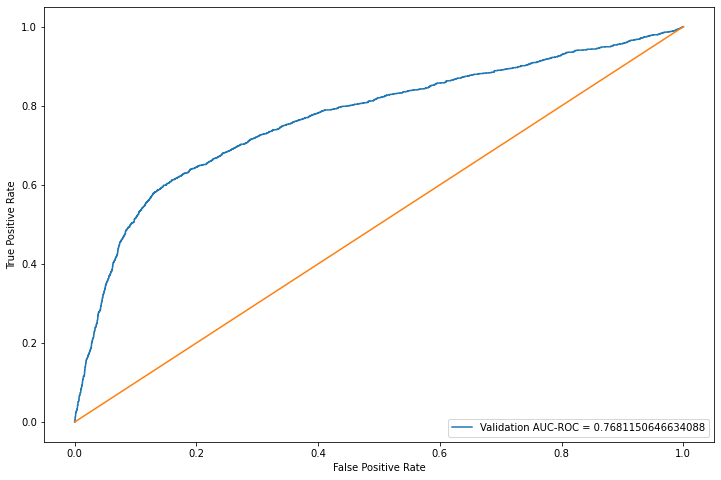

In [21]:
# AUC Curve
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(ytest, pred) 
auc = roc_auc_score(ytest, pred) 
plt.figure(figsize = (12, 8)) 
plt.plot(fpr, tpr, label = "Validation AUC-ROC = " + str(auc)) 
x = np.linspace(0, 1, 1000)
plt.plot(x, x, linestyle = '-')
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.legend(loc = 4) 
plt.show()

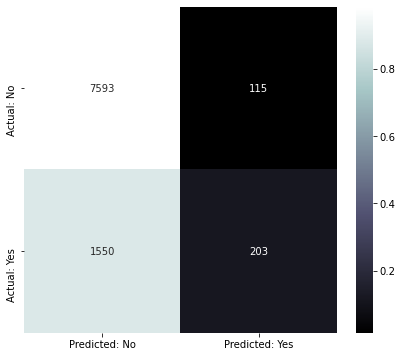

In [22]:
# Confusion Matrix
pred_val = model.predict(xtest)

label_preds = pred_val

cm = confusion_matrix(ytest, label_preds)


def plot_confusion_matrix(cm, normalized=True, cmap='bone'):
    plt.figure(figsize = [7, 6])
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels = ['Predicted: No', 'Predicted: Yes'], yticklabels = ['Actual: No','Actual: Yes'], cmap = cmap)

plot_confusion_matrix(cm, ['No', 'Yes'])

In [23]:
# Recall Score
recall_score(ytest, pred_val)

0.11580148317170565

### Cross Validation

In [24]:
def cv_score(ml_model, rstate = 12, thres = 0.5, cols = df.columns):
    i = 1
    cv_scores = []
    df1 = df.copy()
    df1 = df[cols]
    
    # 5 Fold cross validation stratified on the basis of target
    kf = StratifiedKFold(n_splits = 5, random_state = rstate, shuffle = True)
    for df_index,test_index in kf.split(df1, y_all):
        print('\n{} of kfold {}'.format(i, kf.n_splits))
        xtr, xvl = df1.loc[df_index], df1.loc[test_index]
        ytr, yvl = y_all.loc[df_index], y_all.loc[test_index]
            
        # Define model for fitting on the training set for each fold
        model = ml_model
        model.fit(xtr, ytr)
        pred_probs = model.predict_proba(xvl)
        pp = []
         
        # Use threshold to define the classes based on probability values
        for j in pred_probs[:, 1]:
            if j > thres:
                pp.append(1)
            else:
                pp.append(0)
         
        # Calculate scores for each fold and print
        pred_val = pp
        roc_score = roc_auc_score(yvl,pred_probs[:, 1])
        recall = recall_score(yvl, pred_val)
        precision = precision_score(yvl, pred_val)
        sufix = ""
        msg = ""
        msg += "ROC AUC Score: {}, Recall Score: {:.4f}, Precision Score: {:.4f} ".format(roc_score, recall, precision)
        print("{}".format(msg))
         
         # Save scores
        cv_scores.append(roc_score)
        i+=1
    return cv_scores

In [25]:
baseline_scores = cv_score(LogisticRegression(), cols = baseline_cols)


1 of kfold 5
ROC AUC Score: 0.7644836090843695, Recall Score: 0.0751, Precision Score: 0.5766 

2 of kfold 5
ROC AUC Score: 0.7782373856746481, Recall Score: 0.0751, Precision Score: 0.6583 

3 of kfold 5
ROC AUC Score: 0.755123911284487, Recall Score: 0.1359, Precision Score: 0.6441 

4 of kfold 5
ROC AUC Score: 0.7582075088478692, Recall Score: 0.1169, Precision Score: 0.6508 

5 of kfold 5
ROC AUC Score: 0.7622040568631837, Recall Score: 0.1112, Precision Score: 0.5821 


In [26]:
all_feat_scores = cv_score(LogisticRegression())


1 of kfold 5
ROC AUC Score: 0.7359798581851814, Recall Score: 0.1236, Precision Score: 0.5159 

2 of kfold 5
ROC AUC Score: 0.7681483917377452, Recall Score: 0.1968, Precision Score: 0.6809 

3 of kfold 5
ROC AUC Score: 0.739250990040391, Recall Score: 0.1683, Precision Score: 0.5728 

4 of kfold 5
ROC AUC Score: 0.7322312829739366, Recall Score: 0.1179, Precision Score: 0.6078 

5 of kfold 5
ROC AUC Score: 0.7588873393240096, Recall Score: 0.1730, Precision Score: 0.5987 


### Reverse Feature Elimination or Backward Selection
<b> First, we built a model using some Baseline Features
    Then, we built a model using all the features
    Now, we will use Backward Selection to select the most appropriate features </b>

In [27]:
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt

# Create the RFE object and rank each feature
model = LogisticRegression()
rfe = RFE(estimator=model, n_features_to_select=1, step=1)
rfe.fit(df, y_all)

RFE(estimator=LogisticRegression(), n_features_to_select=1)

In [28]:
ranking_df = pd.DataFrame()
ranking_df['Feature_name'] = df.columns
ranking_df['Rank'] = rfe.ranking_

In [29]:
# Ranking the features with respect to their ranks
ranked = ranking_df.sort_values(by=['Rank'])
ranked

,Feature_name,Rank
13,current_balance,1
16,average_monthly_balance_prevQ,2
7,occupation_company,3
15,average_monthly_balance_prevQ2,4
21,current_month_balance,5
22,previous_month_balance,6
19,current_month_debit,7
10,occupation_self_employed,8
9,occupation_salaried,9
11,occupation_student,10


In [30]:
rfe_top_10_scores = cv_score(LogisticRegression(), cols = ranked['Feature_name'][:10].values)


1 of kfold 5
ROC AUC Score: 0.7986881101633954, Recall Score: 0.2281, Precision Score: 0.7362 

2 of kfold 5
ROC AUC Score: 0.8050442914397288, Recall Score: 0.2234, Precision Score: 0.7556 

3 of kfold 5
ROC AUC Score: 0.7985130070256687, Recall Score: 0.2205, Precision Score: 0.7250 

4 of kfold 5
ROC AUC Score: 0.7935095616193245, Recall Score: 0.2120, Precision Score: 0.7360 

5 of kfold 5
ROC AUC Score: 0.7942222838028076, Recall Score: 0.1911, Precision Score: 0.6745 


In [31]:
cv_score(LogisticRegression(), cols = ranked['Feature_name'][:10].values, thres=0.14)


1 of kfold 5
ROC AUC Score: 0.7986881101633954, Recall Score: 0.8308, Precision Score: 0.2836 

2 of kfold 5
ROC AUC Score: 0.8050442914397288, Recall Score: 0.8375, Precision Score: 0.2902 

3 of kfold 5
ROC AUC Score: 0.7985130070256687, Recall Score: 0.8279, Precision Score: 0.2897 

4 of kfold 5
ROC AUC Score: 0.7935095616193245, Recall Score: 0.8213, Precision Score: 0.2840 

5 of kfold 5
ROC AUC Score: 0.7942222838028076, Recall Score: 0.8108, Precision Score: 0.2927 


[0.7986881101633954,
 0.8050442914397288,
 0.7985130070256687,
 0.7935095616193245,
 0.7942222838028076]

### Comparison of Different Models Fold-Wise
<li><b> Baseline Model</b></li>
<li><b> Model based on all features</b></li>
<li><b> Model based on Top 10 features obtained from RFE</b></li>

In [32]:
results_df = pd.DataFrame({'baseline':baseline_scores, 'all_feats': all_feat_scores, 'rfe_top_10': rfe_top_10_scores})

<AxesSubplot:>

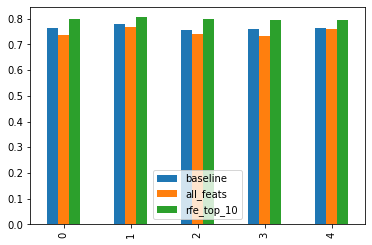

In [33]:
results_df.plot(y=["baseline", "all_feats", "rfe_top_10"], kind="bar")

<b>Here, we can see that the model based on RFE is giving the best result for each fold</b>